Bring in libraries and install all needed dependencies 


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
import pandas as pd
import numpy as np
from sodapy import Socrata
from sqlalchemy import create_engine
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from descartes import PolygonPatch

pd.set_option('display.max_row', 1000)

Grab / downloading the data from NYC Open Data. Done this way because of the colab notebooks limit on RAM. If using the API then RAM will fill up and crash. Also good to note that the column titles change between the csv (upper case) and json (lower case)

In [ ]:
!curl https://data.cityofnewyork.us/api/views/8h9b-rp9u/rows.csv?accessType=DOWNLOAD -o arrests.csv

In [9]:
df = pd.read_csv("arrests.csv", low_memory=False)

API json call if needed to be used

In [0]:
#Grab dataset from NYC Open Data
#client = Socrata("data.cityofnewyork.us",
#                 "ZpOD8bQBSZTZIumGEtxcGL3FB")
#
#results = client.get("8h9b-rp9u", limit=4500000)

# Convert to pandas DataFrame
#df = pd.DataFrame.from_records(results)

RegEx used to clean the date data

In [10]:
df.ARREST_DATE.replace(to_replace = '(\d\d)/(\d\d)/10(\d\d)', value=r'\1/\2/20\3', inplace = True, regex=True )
df.ARREST_DATE.replace(to_replace = '(\d\d)/(\d\d)/10(\d\d)', value=r'\1/\2/20\3', inplace = True, regex=True )

In [11]:
#Reformat the date by removing the T and swapping the - for /
df['ARREST_DATE'] = df['ARREST_DATE'].str.replace('T',' ')
df['ARREST_DATE'] = df['ARREST_DATE'].str.replace('-','/')

In [12]:
#Convert to pandas datetime
df['ARREST_DATE'] = pd.to_datetime(df.ARREST_DATE, format='%m/%d/%Y', cache=True)

In [13]:
#Drop any records with no date or are outside the range of 2006-2018
df.drop(df[df.ARREST_DATE.dt.year < 2006].index, inplace=True)
df.drop(df[df.ARREST_DATE.dt.year > 2018].index, inplace=True)
df.drop(df[df.ARREST_DATE.dt.year.isna()].index, inplace=True)

In [14]:
#Replacement for borough name from letter 
df['ARREST_BORO'] = df['ARREST_BORO'].str.replace('Q','Queens')
df['ARREST_BORO'] = df['ARREST_BORO'].str.replace('B','Bronx')
df['ARREST_BORO'] = df['ARREST_BORO'].str.replace('K','Brooklyn')
df['ARREST_BORO'] = df['ARREST_BORO'].str.replace('M','Manhattan')
df['ARREST_BORO'] = df['ARREST_BORO'].str.replace('S','Staten Island')

In [15]:
#Clean the law category data
df['LAW_CAT_CD'] = df['LAW_CAT_CD'].str.replace('F','Felony')
df['LAW_CAT_CD'] = df['LAW_CAT_CD'].str.replace('M','Misdemeanor')
df['LAW_CAT_CD'] = df['LAW_CAT_CD'].str.replace('V','Violation')
df.drop(df[df.LAW_CAT_CD == 'I'].index, inplace=True)

In [16]:
#Replace sex to be words than letter 
df['PERP_SEX'] = df['PERP_SEX'].str.replace('F','Female')
df['PERP_SEX'] = df['PERP_SEX'].str.replace('M','Male')

In [17]:
#Convert geo data to be numerical
df.Latitude = pd.to_numeric(df.Latitude, downcast='float')
df.Longitude  = pd.to_numeric(df.Longitude, downcast='float')

In [18]:
#Bucket the age groups
df.AGE_GROUP = pd.Categorical(df.AGE_GROUP, ordered=True, categories=['<18', '18-24',  '25-44', '45-64', '65+'])

In [19]:
# We have the longitude and latitude so the other coordinates are not needed 
to_drop = ['X_COORD_CD','Y_COORD_CD']
df = df.drop(to_drop, axis='columns')

In [20]:
# U is unknown, same is NULL.
df.PERP_SEX.replace(to_replace = 'U', value=np.nan, inplace = True)

# Very small amount of OTHER values
df.PERP_RACE.replace(to_replace = 'OTHER', value=np.nan, inplace = True)

# Very small amount of OTHER values
df.PERP_RACE.replace(to_replace = 'UNKNOWN', value=np.nan, inplace = True)


In [21]:
df['LAW_CAT_CD'] = pd.Categorical(df['LAW_CAT_CD'])
df['PERP_SEX'] = pd.Categorical(df['PERP_SEX'])
df['PERP_RACE'] = pd.Categorical(df['PERP_RACE'])

In [22]:
#Add a counter column for pivot table sum
df['COUNTER'] = 1
#Create column for arrest year
df['YEAR'] = df.ARREST_DATE.dt.year.astype(int)


The code below will create the chart for Marijuana possession arrests by year. You can see a drop starting in 2013 once de Basio became mayor of NYC

[Text(0.5, 0, 'Year'), Text(0.5, 1.0, 'Marijuana Possession Arrests')]

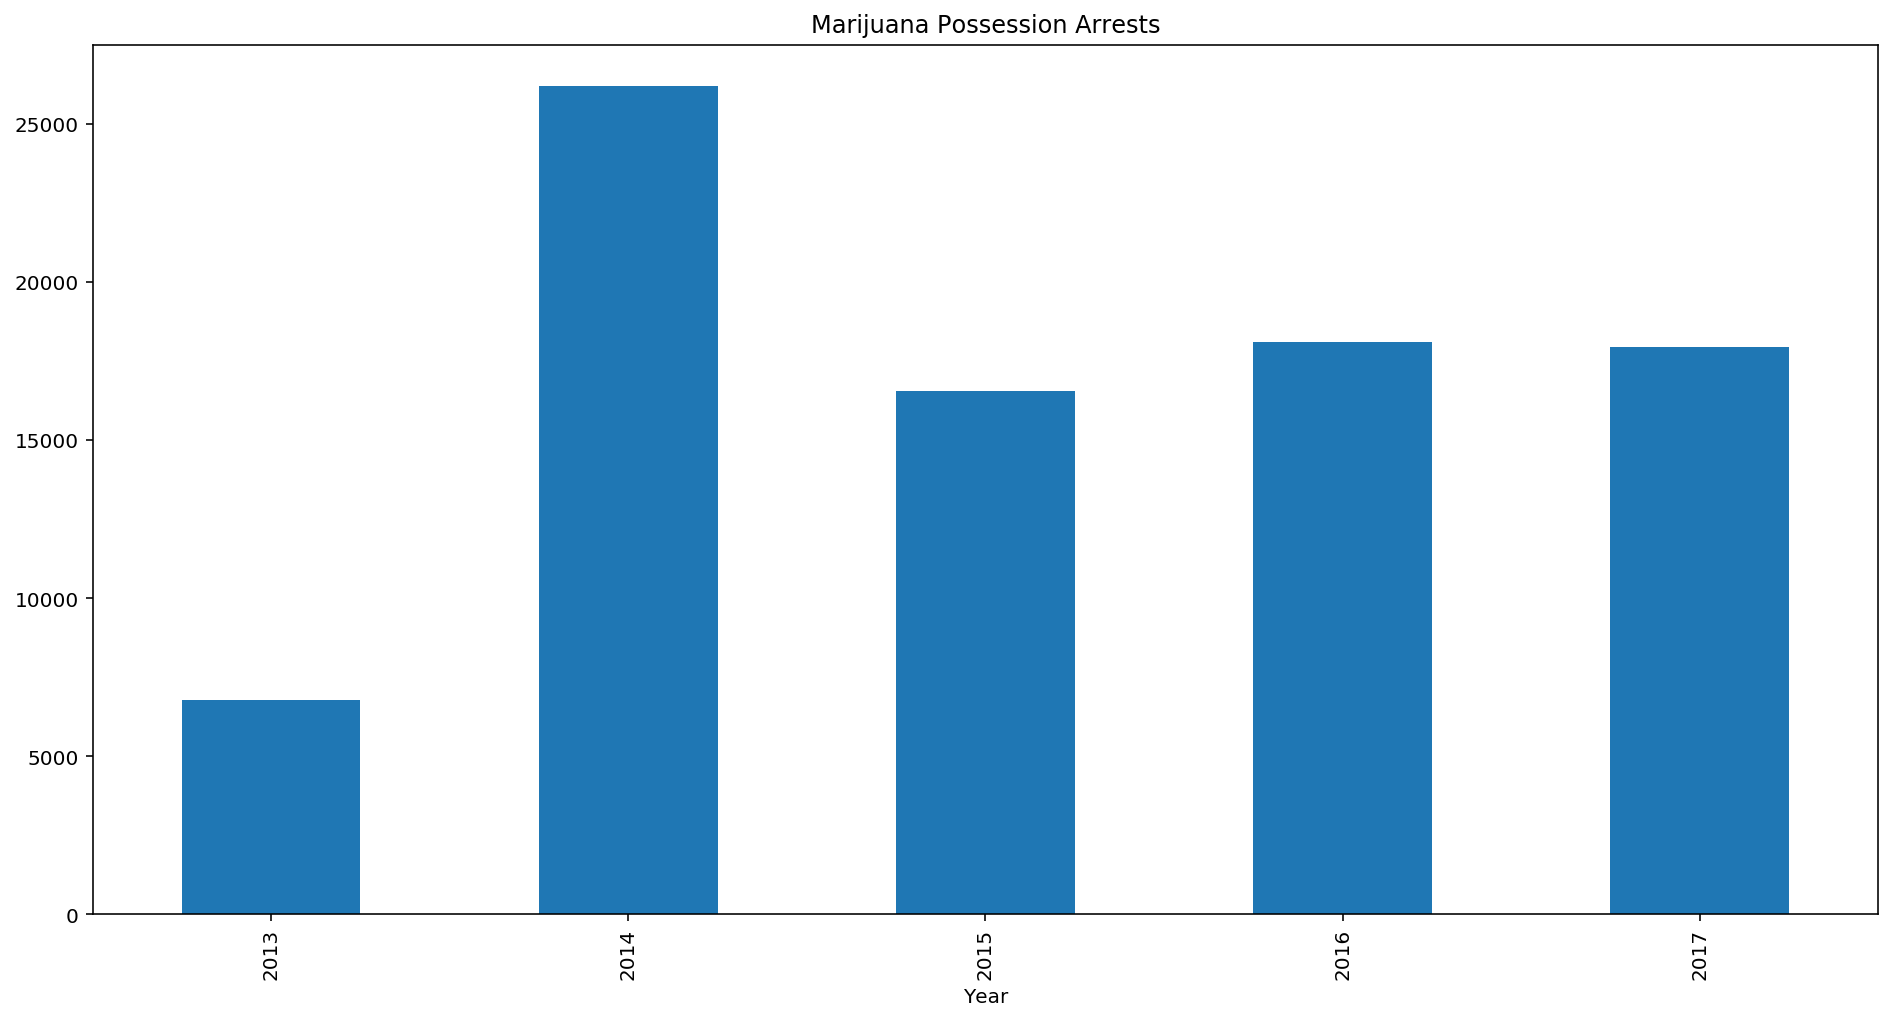

In [23]:
#Creates a chart of weed arrests by year
df_pot = pd.pivot_table(
    data = df[(df.PD_DESC == 'MARIJUANA, POSSESSION 4 & 5')],
    index = df.ARREST_DATE.dt.year, 
    columns = df.PD_DESC, 
    values = 'COUNTER', 
    aggfunc = 'count'
)
fig, ax = plt.subplots()

#ax.axvline(2013, color ='r')

df_pot.plot(kind='bar',figsize=(16,8),legend=False,ax=ax).set(xlabel='Year',title='Marijuana Possession Arrests')


The code below creates a stacked bar chart of total crimes broken in age group buckets by male or female. +65 year old females account for the fewest arrests in the city.

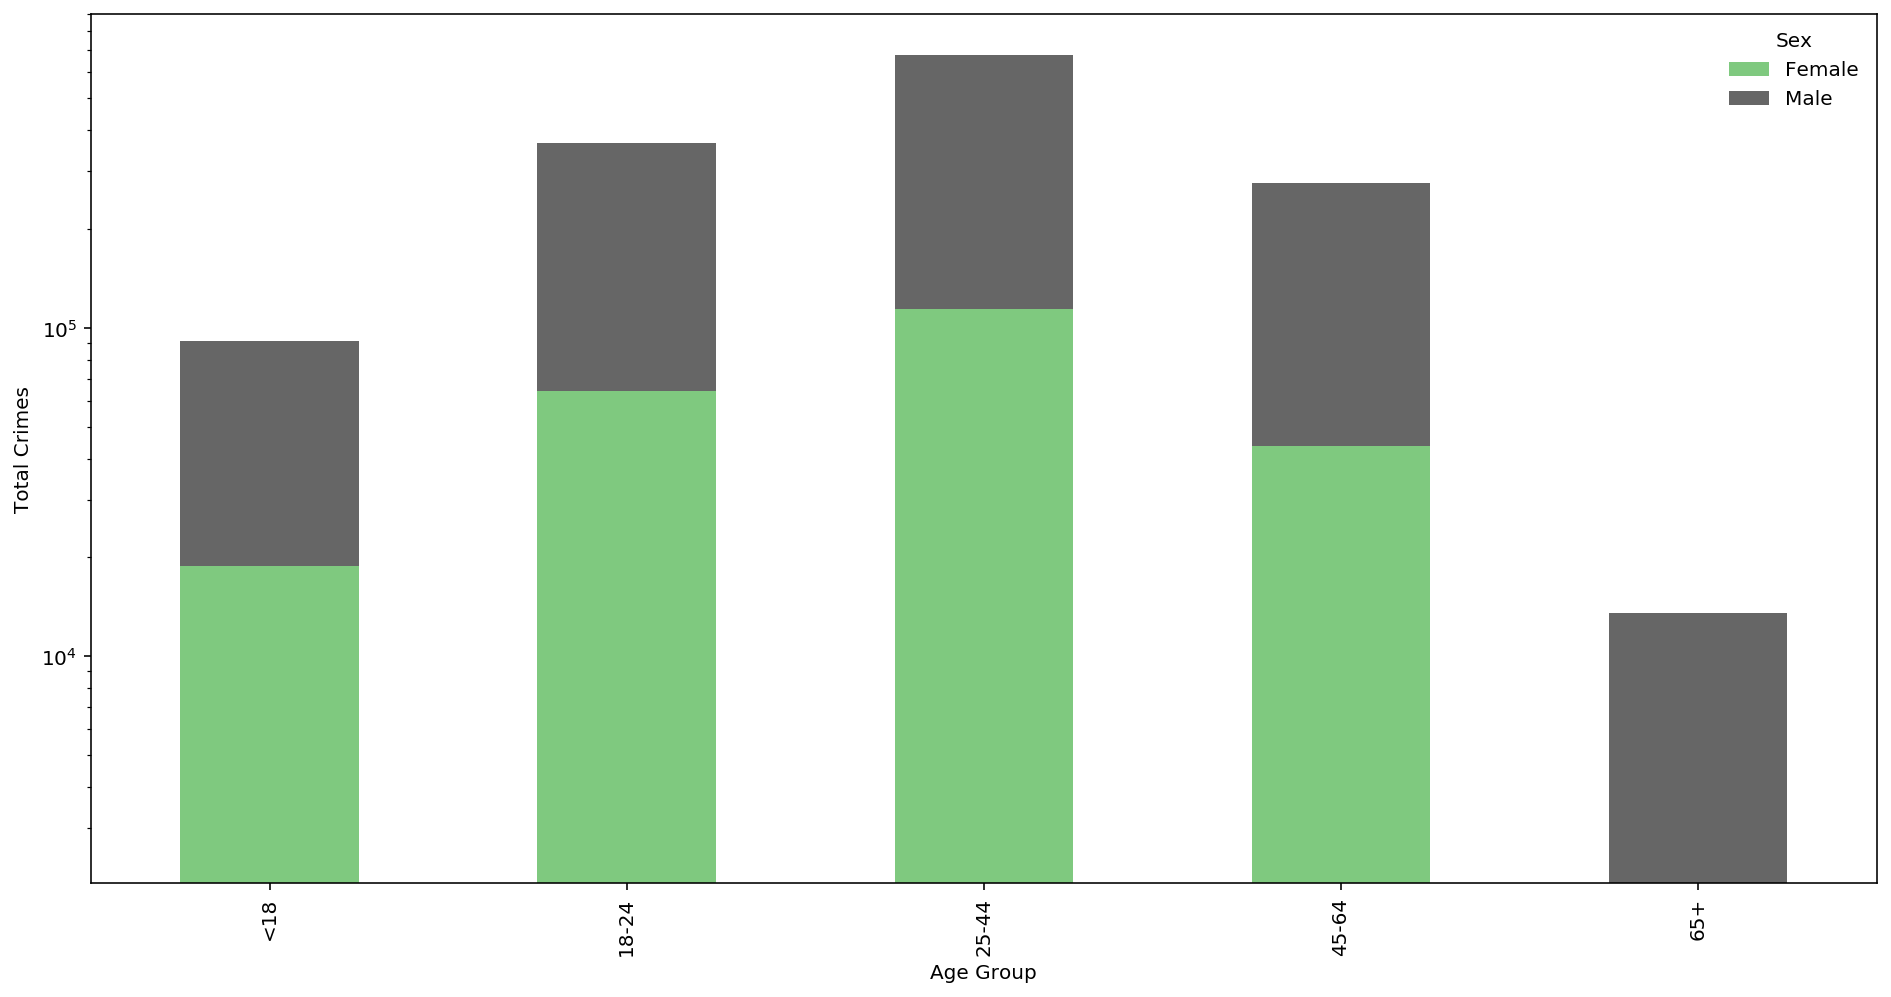

In [24]:
df_age = pd.pivot_table(
   data = df,
   index = df.AGE_GROUP,
   columns = df.PERP_SEX,
   values = 'COUNTER',
   aggfunc = 'count'
)


fig, ax = plt.subplots()

df_age.plot.bar(stacked=True,figsize=(16,8), colormap='Accent',logy=True,ax=ax).set(xlabel='Age Group', ylabel='Total Crimes')
ax.legend(title='Sex',frameon=False)

The code below creates a heatmap of crimes broken down by each day of the calendar year. As you can see the end of December has relatively few arrests.

[Text(0.5, 42.0, 'Day of Month'), Text(0.5, 1, 'Crimes by Day Heatmap')]

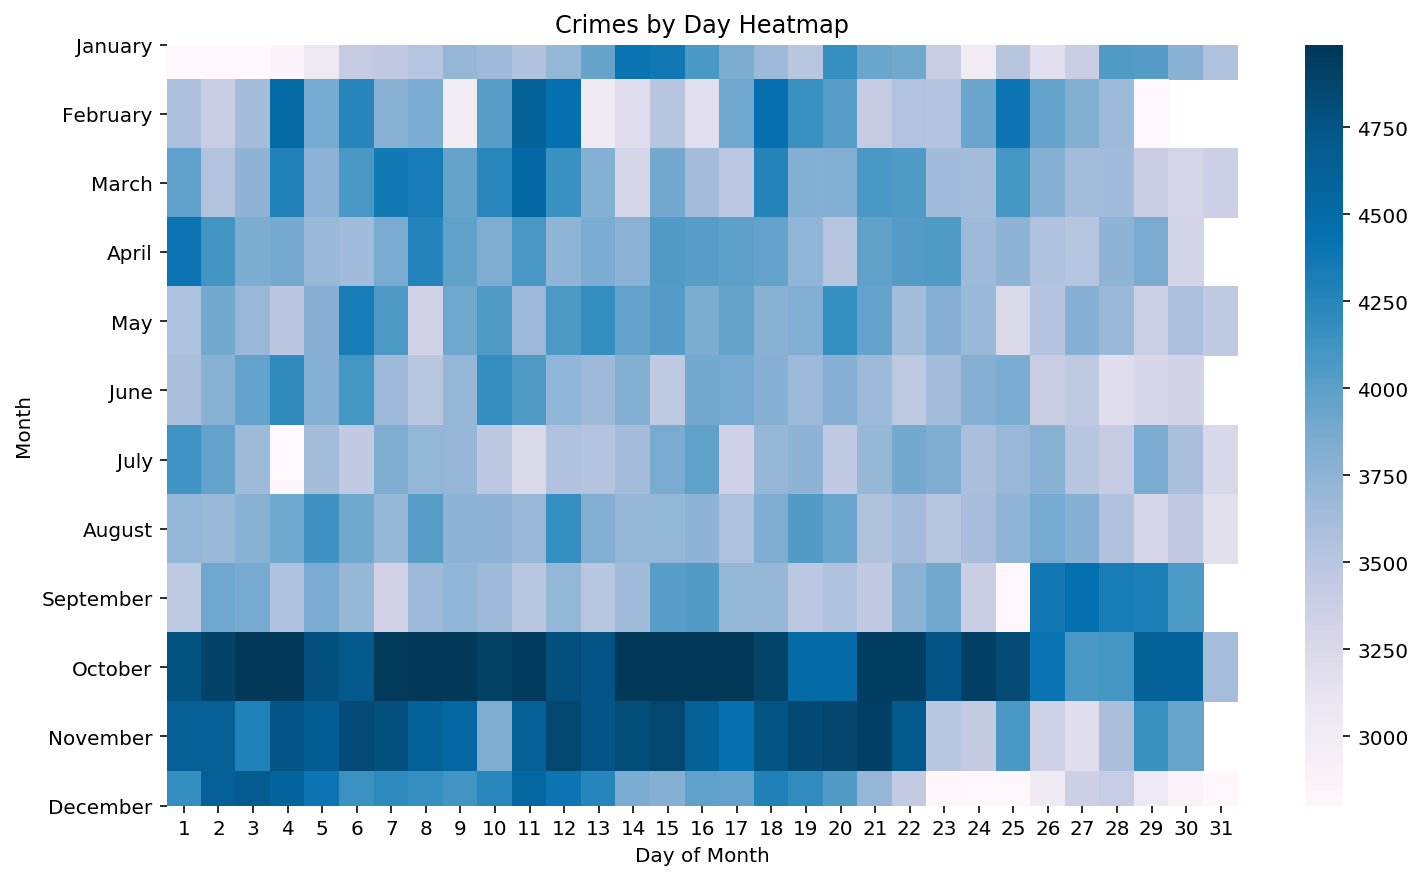

In [25]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['MONTH'] = pd.Categorical(df.ARREST_DATE.dt.month_name(), categories = months, ordered=True)


df_heatmap = pd.pivot_table(
    data = df, 
    index = df.MONTH, 
    columns = df.ARREST_DATE.dt.day, 
    values = 'COUNTER', 
    aggfunc = 'count'
)
df_heatmap.index.names = ['Month']
plt.figure(figsize=(12,7))
sns.heatmap(df_heatmap, cmap='PuBu', robust=True).set(xlabel='Day of Month', title='Crimes by Day Heatmap')

Load NYC shapefile and isolate specific longitude and latitudes.

In [26]:
# Load the shapefile
df_nyc = gpd.GeoDataFrame.from_file('https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=Shapefile')
# Limit the data to only Manhattan neighborhoods 
df_manhattan = df_nyc[df_nyc.boro_name =='Manhattan']
# Clean Long and Lat data
clean_mask = (df.Latitude > 40) & (df.Latitude < 41) & (df.Longitude < -72) & (df.Longitude > -74.5)
df_geo = df[clean_mask]


Create a density plot for prostitution arrests

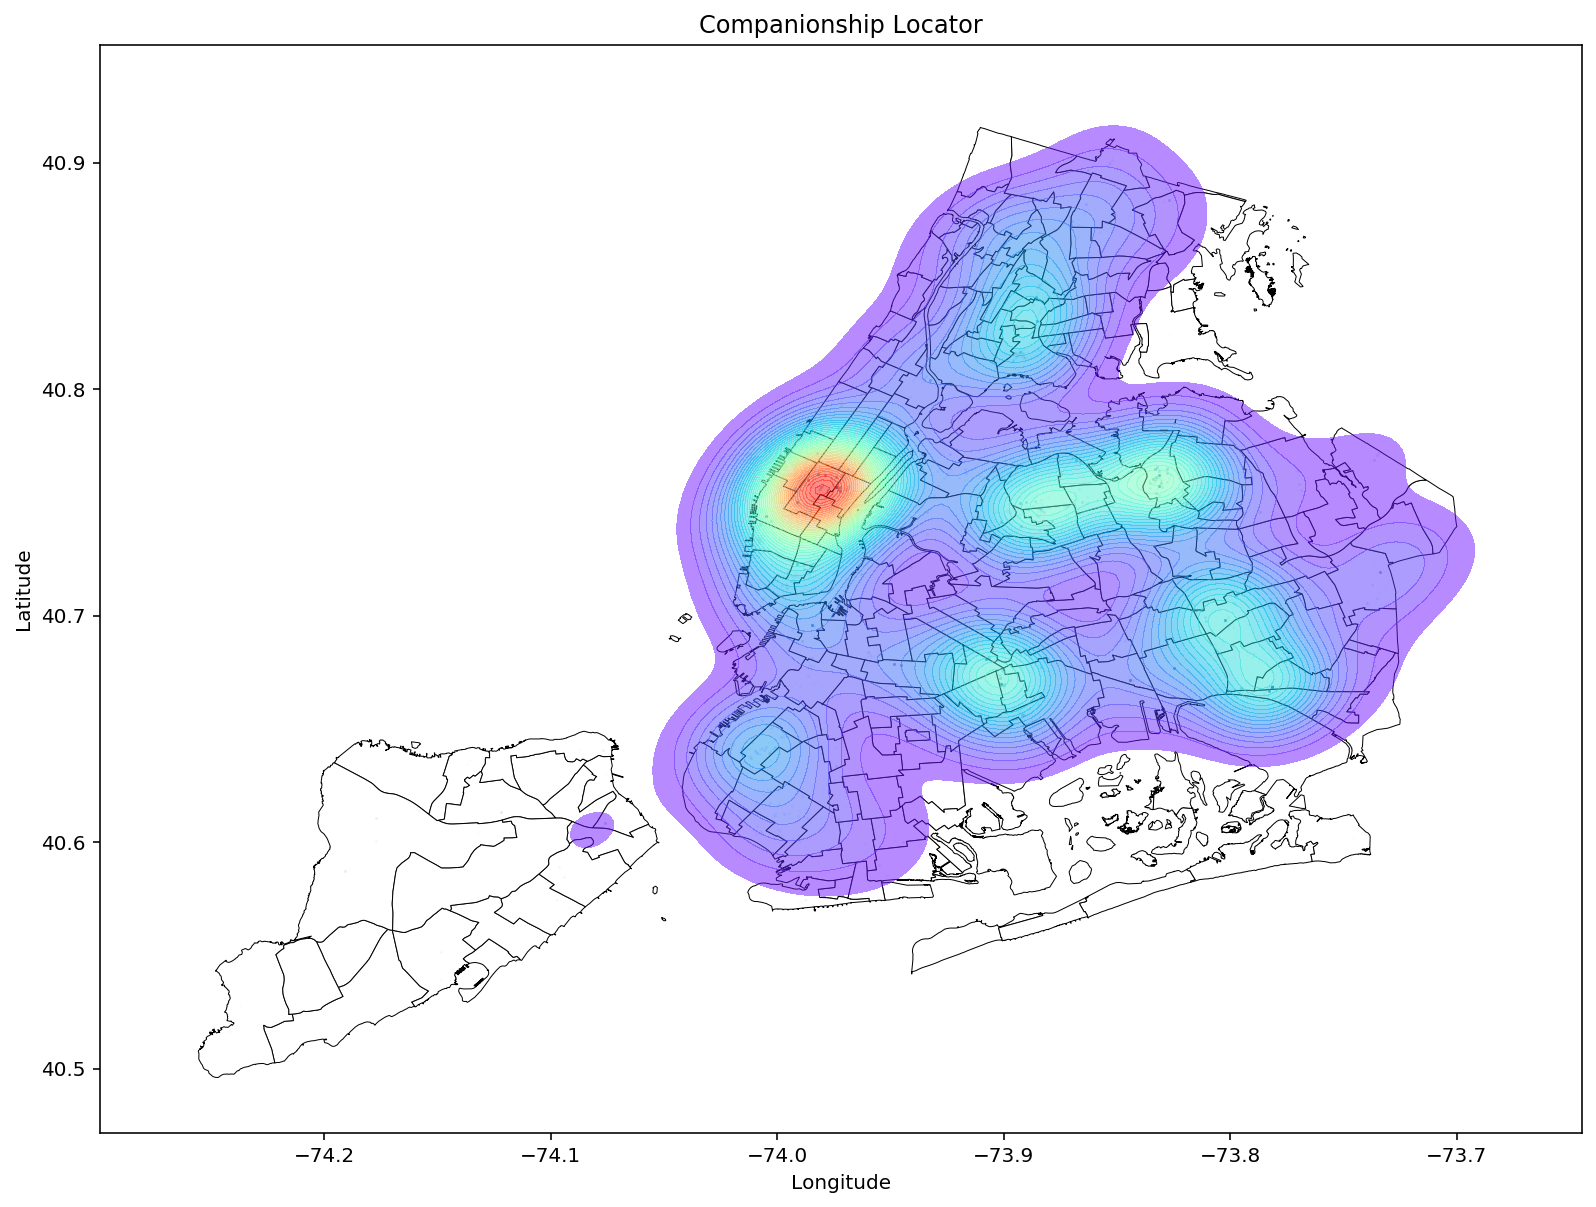

In [27]:
df_prost = df_geo[(df_geo.PD_DESC == 'PROSTITUTION')] # & (df_geo.ARREST_DATE.dt.month == 2) & (df_geo.ARREST_DATE.dt.day == 14)]

base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(20, 15))

scatterplot = df_prost.plot(
    kind='scatter',
    title='Companionship Locator',
    x='Longitude',
    y='Latitude',
    figsize=(15, 10),
    s=0.25,
    alpha=0.02,
    ax=base)

#df_prost_sample = df_prost.sample(20000)

sns.kdeplot(
    df_prost.Longitude,
    df_prost.Latitude,
    gridsize=200,  # controls the resolution
    cmap=plt.cm.rainbow,  # color scheme
    shade=True,# whether to have a density plot (True), or just the contours (False)
    alpha=0.5,
    shade_lowest=False,
    n_levels=50,# How many contours/levels to have
    ax=scatterplot
)